In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D,AveragePooling1D, Flatten,Conv2D,SpatialDropout1D, Dropout, GlobalAveragePooling1D,GlobalMaxPooling1D
from keras.layers import BatchNormalization

from keras.layers import LSTM
from keras.layers import Embedding

# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# https://www.kaggle.com/code/danofer/deep-protein-sequence-family-classification/notebook

In [3]:
data = pd.read_csv("protein_class_prep/pdb_data_no_dups.csv")

In [4]:
sequnce = pd.read_csv("protein_class_prep/pdb_data_seq.csv")

In [5]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [6]:
sequnce.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [7]:
# the same columns in both datasets
sequnce.drop(columns=['residueCount', 'macromoleculeType'], inplace=True)

In [8]:
df = data.merge(sequnce, how='inner', on='structureId')

In [9]:
# Drop rows with missing labels
df = df[[type(c) == type('') for c in df.classification.values]]
df = df[[type(c) == type('') for c in df.sequence.values]]
# select proteins
df = df[df.macromoleculeType == 'Protein']
df.reset_index()
print(df.shape)
df.head()

(346321, 16)


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


remove some longer/shorter sequences

In [10]:
print(df.residueCount.quantile(0.9))
df.residueCount.describe()

5628.0


count    346321.000000
mean       4708.585243
std       26484.309151
min           3.000000
25%         398.000000
50%         856.000000
75%        1976.000000
max      313236.000000
Name: residueCount, dtype: float64

In [11]:
df = df.loc[df.residueCount<1200]
print(df.shape[0])
df.residueCount.describe()

212258


count    212258.000000
mean        529.197415
std         305.092634
min           3.000000
25%         280.000000
50%         485.000000
75%         768.000000
max        1198.000000
Name: residueCount, dtype: float64

Only 10 most common classes are considered - because computational limitations

In [12]:
# count numbers of instances per class
cnt = Counter(df.classification)
# select only K most common classes! - was 10 by default
top_classes = 10
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

at least 4015 instances per class


In [13]:
# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.classification]]
print(str(df.shape[0]) + " instances after")

212258 instances before
111166 instances after


In [14]:
seqs = df.sequence.values
lengths = [len(s) for s in seqs]

Transform labels

In [35]:
# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

In [38]:
# maximum length of sequence, everything afterwards is discarded! Default 256
# max_length = 256
max_length = 350

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

Build keras model and fit

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [40]:
embedding_dim = 25 # orig 8

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu',dilation_rate=1))
# model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu')) #orig
model.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu',dilation_rate=1))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(AveragePooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) # orig
model.add(Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu',dilation_rate=2)) 
model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(AveragePooling1D(pool_size=2))

# model.add(Flatten()) ## Could do pooling instead 
# GlobalAveragePooling1D,GlobalMaxPooling1D
model.add(GlobalAveragePooling1D())

model.add(Dense(256, activation='relu')) # 128
model.add(BatchNormalization())
model.add(Dense(128, activation='relu')) # 128
model.add(BatchNormalization())
model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 25)           650       
                                                                 
 conv1d (Conv1D)             (None, 350, 128)          12928     
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 128)          82048     
                                                                 
 average_pooling1d (Average  (None, 173, 128)          0         
 Pooling1D)                                                      
                                                                 
 conv1d_2 (Conv1D)           (None, 161, 128)          114816    
                                                                 
 batch_normalization (Batch  (None, 161, 128)          512       
 Normalization)                                         

In [41]:
es = EarlyStopping(monitor='val_acc', verbose=1, patience=3)

model.fit(X_train, y_train,  batch_size=128, verbose=1, validation_split=0.15,callbacks=[es],epochs=25) # epochs=15, # batch_size=128

Epoch 1/25
591/591 [==============================] - 313s 525ms/step - loss: 1.4923 - accuracy: 0.4874 - val_loss: 2.1831 - val_accuracy: 0.2479
Epoch 2/25
591/591 [==============================] - 275s 464ms/step - loss: 1.0262 - accuracy: 0.6629 - val_loss: 1.9687 - val_accuracy: 0.3958
Epoch 3/25
591/591 [==============================] - 157s 266ms/step - loss: 0.7589 - accuracy: 0.7568 - val_loss: 2.3381 - val_accuracy: 0.4295
Epoch 4/25
591/591 [==============================] - 184s 312ms/step - loss: 0.6093 - accuracy: 0.8043 - val_loss: 3.6506 - val_accuracy: 0.3043
Epoch 5/25
591/591 [==============================] - 191s 322ms/step - loss: 0.5095 - accuracy: 0.8376 - val_loss: 2.2522 - val_accuracy: 0.4907
Epoch 6/25
591/591 [==============================] - 193s 327ms/step - loss: 0.4427 - accuracy: 0.8583 - val_loss: 2.7563 - val_accuracy: 0.4780
Epoch 7/25
591/591 [==============================] - 192s 325ms/step - loss: 0.3923 - accuracy: 0.8740 - val_loss: 1.7948 -

In [48]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

695/695 [==============================] - 16s 22ms/step


In [50]:
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train-acc = 0.7735685692439167
test-acc = 0.7332014032562741


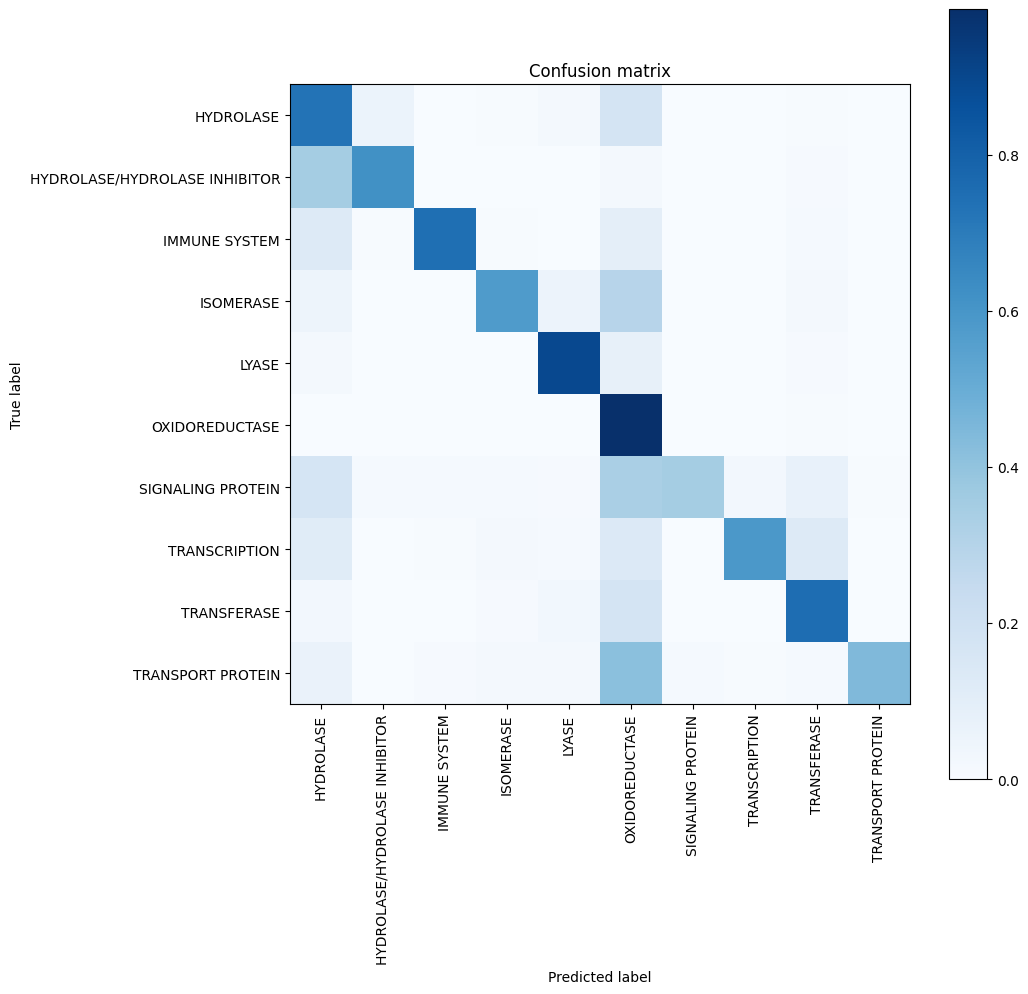

                               precision    recall  f1-score   support

                    HYDROLASE       0.78      0.73      0.76      5854
HYDROLASE/HYDROLASE INHIBITOR       0.60      0.62      0.61       946
                IMMUNE SYSTEM       0.97      0.75      0.85      2138
                    ISOMERASE       0.76      0.58      0.66       813
                        LYASE       0.76      0.89      0.82      1203
               OXIDOREDUCTASE       0.49      0.99      0.65      3226
            SIGNALING PROTEIN       0.91      0.35      0.50      1030
                TRANSCRIPTION       0.94      0.59      0.72      1400
                  TRANSFERASE       0.90      0.76      0.82      4666
            TRANSPORT PROTEIN       0.95      0.44      0.60       958

                     accuracy                           0.73     22234
                    macro avg       0.81      0.67      0.70     22234
                 weighted avg       0.80      0.73      0.74     22234


In [51]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [53]:
model.save('trained_model/protein_classification.keras')

Test example

In [63]:
X_test = tokenizer.texts_to_sequences(seqs[0])
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [65]:
X_test

array([[ 0,  0,  0, ...,  0,  0,  9],
       [ 0,  0,  0, ...,  0,  0, 16],
       [ 0,  0,  0, ...,  0,  0,  9],
       ...,
       [ 0,  0,  0, ...,  0,  0,  3],
       [ 0,  0,  0, ...,  0,  0,  6],
       [ 0,  0,  0, ...,  0,  0,  4]])

In [66]:
# I want to predict the class of the protein in X_test variable


True class: HYDROLASE


In [67]:
seqs[0]

'TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMVVEIPRWTNAKLEITKEETLNPIIQDTKKGKLRFVRNCFPHHGYIHNYGAFPQTWEDPNVSHPETKAVGDNEPIDVLEIGETIAYTGQVKQVKALGIMALLDEGETDWKVIAIDINDPLAPKLNDIEDVEKYFPGLLRATNEWFRIYKIPDGKPENQFAFSGEAKNKKYALDIIKETHDSWKQLIAGKSSDSKGIDLTNVTLPDTPTYSKAASDAIPPASLKADAPIDKSIDKWFFISGSV'

In [68]:
# I want to predict the class of the protein in X_test variable
model.predict(X_test)

9/9 [==============================] - 0s 22ms/step


array([[8.12e-01, 1.72e-01, 1.66e-07, ..., 2.60e-07, 1.54e-02, 2.90e-06],
       [8.29e-01, 1.52e-01, 1.18e-07, ..., 2.64e-07, 1.74e-02, 2.99e-06],
       [8.12e-01, 1.72e-01, 1.66e-07, ..., 2.60e-07, 1.54e-02, 2.90e-06],
       ...,
       [8.34e-01, 1.52e-01, 1.05e-07, ..., 1.98e-07, 1.29e-02, 2.50e-06],
       [8.29e-01, 1.55e-01, 1.25e-07, ..., 2.24e-07, 1.49e-02, 2.53e-06],
       [7.60e-01, 2.31e-01, 1.25e-07, ..., 9.48e-08, 8.49e-03, 1.83e-06]],
      dtype=float32)

x

In [69]:
# I want to predict the class of the following protein 'TYTTRQIGAKNTLEYKV'
X_test_2 = tokenizer.texts_to_sequences(['TYTTRQIGAKNTLEYKV'])

In [70]:
# I want to predict the class of the following protein 'TYTTRQIGAKNTLEYKV'
X_test_2 = tokenizer.texts_to_sequences(['TYTTRQIGAKNTLEYKV'])
X_test_2 = sequence.pad_sequences(X_test_2, maxlen=max_length)
X_test_2

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [71]:
# I want to visualize the prediction
model.predict(X_test_2)

1/1 [==============================] - 0s 16ms/step


array([[8.15e-02, 1.12e-03, 6.80e-06, 2.52e-04, 1.05e-05, 1.13e-01,
        6.94e-06, 3.59e-04, 8.04e-01, 7.32e-04]], dtype=float32)

In [75]:
# I want to write the class name instead of the class number and replace it

lb.classes_


array(['HYDROLASE', 'HYDROLASE/HYDROLASE INHIBITOR', 'IMMUNE SYSTEM',
       'ISOMERASE', 'LYASE', 'OXIDOREDUCTASE', 'SIGNALING PROTEIN',
       'TRANSCRIPTION', 'TRANSFERASE', 'TRANSPORT PROTEIN'], dtype='<U29')

In [79]:
from keras.preprocessing.text import Tokenizer

# Convert the tokenizer to a JSON string and save it to a file
tokenizer_json = tokenizer.to_json()
with open('trained_model/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [77]:
from keras.models import load_model
model_2 = load_model('trained_model/protein_classification.keras')

In [78]:
model_2

In [81]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing import sequence

with open('trained_model/tokenizer.json', 'r', encoding='utf-8') as f:
    loaded_tokenizer_json = f.read()
    loaded_tokenizer = tokenizer_from_json(loaded_tokenizer_json)

In [84]:
loaded_tokenizer

In [100]:
test_protein = seqs[0]

In [101]:
max_length = 350

test_protein = loaded_tokenizer.texts_to_sequences(test_protein)
test_protein = sequence.pad_sequences(X_test_2, maxlen=max_length)

In [102]:
test_protein

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [103]:
predicted_protein = model_2.predict(test_protein)

1/1 [==============================] - 0s 10ms/step


In [115]:
predicted_protein = pd.DataFrame(predicted_protein)

In [132]:
col_names = ['HYDROLASE',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'IMMUNE SYSTEM',
 'ISOMERASE',
 'LYASE',
 'OXIDOREDUCTASE',
 'SIGNALING PROTEIN',
 'TRANSCRIPTION',
 'TRANSFERASE',
 'TRANSPORT PROTEIN']

In [134]:
predicted_protein.columns = col_names

In [135]:
predicted_protein

,HYDROLASE,HYDROLASE/HYDROLASE INHIBITOR,IMMUNE SYSTEM,ISOMERASE,LYASE,OXIDOREDUCTASE,SIGNALING PROTEIN,TRANSCRIPTION,TRANSFERASE,TRANSPORT PROTEIN
0,0.081481,0.001121,0.000007,0.000252,0.000011,0.11253,0.000007,0.000359,0.803501,0.000732


In [137]:
predicted_class = predicted_protein.max().idxmax()

In [138]:
predicted_class

'TRANSFERASE'